In [1]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.utils import resample
from sklearn.metrics import r2_score, ndcg_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.utils import shuffle

from scipy.stats import spearmanr

import sys
sys.path.append('..')
from util.Datasets import *
from util.model import *

def ndcg(y_true, y_pred):
    #y_true_normalized = (y_true - y_true.mean()) / y_true.std()
    #y_true_normalized = y_true_normalized - min(y_true_normalized)
    y_true_normalized = y_true - min(y_true)
    #y_pred_normalized = y_pred - min(y_pred)
    #y_pred_normalized = (y_pred - y_pred.mean()) / y_pred.std()
    return ndcg_score(y_true_normalized.reshape(1, -1), y_pred.reshape(1, -1))

In [2]:
# FILEPATH = '/home/jyang4/ProtTP/data/AllPredictions.csv'
# dataframe = pd.read_csv(FILEPATH)
# dataset = GB1Dataset(dataframe, 'one-hot', ["Triad-FixedBb-dG", 
#                             "EvMutation",
#                             "esm_msa1_t12_100M_UR50S-Naive-ColumnUnmasked"], SD_only = False)

In [ ]:
# #Calculate embeddings if necessary
# with open('/home/jyang4/ProtTP/saved/AE+AD/AE+AD.json', 'r') as f:
#     config = json.load(f)

# model = ProtTP(config["model_config"], dataset)
# model.load_state_dict(torch.load('/home/jyang4/ProtTP/saved/AE+AD/best.pth'))

# with torch.no_grad():
#     X = dataset.X#.to(device)
#     if config["model_config"]["kl_div_weight"] != 0:
#         mu, log_var = model.encode(X)
#         embeddings = model.reparameterize(mu, log_var)
#     else:
#         embeddings = model.encode(X)
#     reconstructions = model.decode(embeddings)

In [8]:
FILEPATH = '/home/jyang4/ProtTP/data/PABP_AllPreds.csv'
dataframe = pd.read_csv(FILEPATH)
attribute_names = ['ESM_ensemble', 'EVMutation'] #'ESM_ensemble'"EVMutation"
dataset = PABPDataset(dataframe = dataframe, encoding = 'one-hot', attribute_names = attribute_names)
dataset.encode_X()
embeddings = np.load('/home/jyang4/ProtTP/saved/AE+AD_PABP2/embeddings.npy')
#embeddings2 = np.load('/home/jyang4/ProtTP/saved/AE+AD_PABP_fullDSM/embeddings.npy')

In [65]:
# FILEPATH = '/home/jyang4/ProtTP/data/GB1_AllPreds.csv'
# dataframe = pd.read_csv(FILEPATH)
# dataset = GB1Dataset(dataframe = dataframe, encoding = 'one-hot', attribute_names = ["Triad-FixedBb-dG"], rank_attributes = True)
# dataset.generate_onehot()
# embeddings = np.load('/home/jyang4/ProtTP/saved/AE+Triad_rank_GB1/embeddings.npy')

In [9]:
model_params = {"booster": "gbtree",
                      "tree_method": "exact",
                      "nthread": 1,
                      "objective": "reg:tweedie",
                      "tweedie_variance_power": 1.5,
                      "eval_metric": "tweedie-nloglik@1.5",
                      "eta": 0.3,
                        "max_depth": 6,
                        "lambda": 1,
                        "alpha": 0
                      }

linear = True
# model_params = {"booster": "gblinear",
#                       "tree_method": "exact",
#                       "nthread": 1,
#                       "verbosity": 0,
#                       "objective": "reg:tweedie",
#                       "tweedie_variance_power": 1.5,
#                       "eval_metric": "tweedie-nloglik@1.5"}

In [5]:
#how listgarten split their dataset
data = dataset.data.sample(frac=1.0, random_state=0)
test = data.sample(frac=0.2, random_state=0)
test

,Unnamed: 0,seq,log_fitness,n_mut,EVMutation,EV_rank,mutant,ESM_ensemble
1779,1779,QRDPSLRKKGSGNIFIKNLHPDIAYKALYDTFSVFGDILSSKIATD...,-1.358679,2,2773.0,2774.0,D138A:N139Y,-12.350963
25895,25895,QRDPSLRKKGSGNLFIKNLHPDIDNKALYDAFSVFGDILSSKIATD...,0.227932,2,28128.0,28638.0,I128L:T145A,-5.521587
10581,10581,QRDPSLRKKGSGNIFIKNLHPDIDNKALYDTFSVFGDILSSKIATD...,-0.059219,2,12130.0,12182.0,I183M:G188C,-10.881437
11187,11187,QRDPSLRKKGSGNIFIKNLHPDIDNKALYDTFSVFGDILSSKFATD...,-1.594549,2,27016.0,27460.0,I157F:K164R,-8.613753
10101,10101,QRDPSLRKKGSGNIFIKNLHPDIDNKAVYDTFSVFSDILSSKIATD...,-2.499452,2,3813.0,3814.0,L142V:G150S,-13.542576
...,...,...,...,...,...,...,...,...
22202,22202,QRDPSLRKKGSGNIFIKNLHPDIDNKALYDSFLVFGDILSSKIATD...,-0.132389,2,19516.0,19697.0,T145S:S147L,-8.555109
5511,5511,QRDPSLRKKGSGNIFIKNLHPDIDNKALYDTFSVFGDIWSSKIATD...,-2.715830,2,1815.0,1816.0,L153W:H172Y,-15.048787
4868,4868,QRDPSLRKKGSGNIFIKNLHPDIDNKALYDTFSVFGDILSSKIATD...,0.061095,2,28139.0,28649.0,I183V:L186Q,-9.459573
35150,35150,QRDPSLRKKGSGNIFIKNWHPDIDNKAFYDTFSVFGDILSSKIATD...,-4.195713,2,519.0,520.0,L133W:L142F,-16.975959


In [10]:
#downstream supervised regression
N_models = 100
N_train_samples = 96
N_test_samples = 96
alpha_list = [1]
#alpha_list = [10**2.5]
#alpha_list = [5**i for i in range(-5,5)]


X_baseline = np.array(dataset.X)
X_OHembed = np.concatenate((np.array(dataset.X), np.array(embeddings)), axis=1)
X_embed = np.array(embeddings)
X_OHzs = np.concatenate((np.array(dataset.X), np.array(dataset.attributes)), axis=1)
#X_OHzs = np.concatenate((np.array(dataset.X), np.array(dataframe['EVMutation']).reshape(-1,1)), axis=1)
X_all = np.concatenate((np.array(dataset.X), np.array(dataset.attributes), np.array(embeddings)), axis=1)
X_zs = np.array(dataset.attributes)
#X_zs = np.array(dataframe['EVMutation']).reshape(-1,1)

inputs = [X_baseline, X_embed,X_OHembed, X_zs, X_OHzs, X_all]
#inputs = [X_OHzs]

results_ndcg = np.zeros((N_models, len(inputs), len(alpha_list)))
results_rho = np.zeros((N_models, len(inputs), len(alpha_list)))
np.random.seed(42)

for k, alpha in enumerate(alpha_list):
    for j, X in enumerate(inputs):
        #do not normalize! it will break the OH+ZS results!
        #scaler = StandardScaler()
        #X = scaler.fit_transform(X)
        y = dataset.y
        #y = dataframe['log_fitness'].values

        seed = 0
        X, y = shuffle(X, y, random_state=seed)
        X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
        #print(len(y_test))

        np.random.seed(42)
        for i in range(N_models):
            X_train, y_train = resample(X_train_all, y_train_all, n_samples=N_train_samples)
            #only run this line if you wish to use a different test size
            #X_test, y_test = resample(X, y, n_samples=N_test_samples)

            if linear:
                clf = Ridge(alpha=alpha)
                clf.fit(X_train, y_train)
                y_pred_test = clf.predict(X_test)
            else:
                #insert kfold cross validation
                train_matrix = xgb.DMatrix(X_train, label = y_train)

                # in reality we should use a validation set, not the test set
                test_matrix = xgb.DMatrix(X_test, label = y_test)
                evallist = [(train_matrix, "train"), (test_matrix, "test")]
                bst = xgb.train(model_params, train_matrix, num_boost_round=1000, early_stopping_rounds=10, evals=evallist, verbose_eval=False)
                best = bst.best_iteration
                y_pred_test = bst.predict(xgb.DMatrix(X_test), iteration_range=(0,best))

                # y_pred = bst.predict(xgb.DMatrix(X), iteration_range=(0,best))
                # df = pd.DataFrame(X)
                # df['y_pred'] = y_pred
                # df['y'] = y
                # df = df.sort_values('y_pred',ascending = False)
                # df =df.reset_index()
                # y_pred_top = df.loc[:N_test_samples-1,'y_pred'].values
                # y_top = df.loc[:N_test_samples-1,'y'].values

            #results_ndcg[i, j] = ndcg(y_top, y_pred_top)
            #results_rho[i, j] = spearmanr(y_top, y_pred_top)[0]

            results_ndcg[i, j, k] = ndcg(y_test, y_pred_test)
            results_rho[i, j, k] = spearmanr(y_test, y_pred_test)[0]

            #exponentiate if the fitness was logged
            #results_ndcg[i, j, k] = ndcg(np.exp(y_test), np.exp(y_pred_test))
            #results_rho[i, j, k] = spearmanr(np.exp(y_test), np.exp(y_pred_test))[0]

In [94]:
#for testing individual models
# scaler = StandardScaler()
# X = scaler.fit_transform(X_baseline)
# y = dataset.y

# X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
# X_train, y_train = resample(X_train_all, y_train_all, n_samples=N_train_samples, random_state=0)
# #print(spearmanr(X_train, y_train)[0])

# clf = Ridge(alpha=1)
# clf.fit(X_train, y_train)
# y_pred_test = clf.predict(X_test)
# print(spearmanr(y_pred_test, y_test)[0])

0.39570640401404594


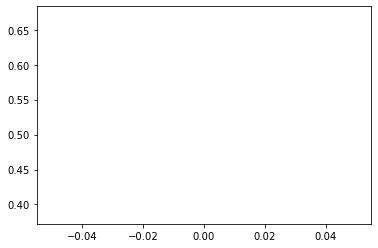

In [118]:
#for visualizing the optimal hyperparameters
plt.plot(np.log10(alpha_list), np.mean(results_rho, axis = 0).T, '-')

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


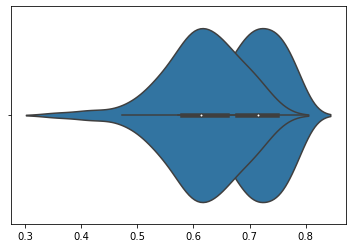

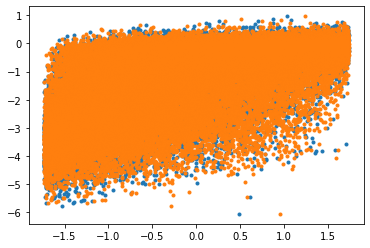

In [11]:
data = dataset.data
all_all_scores = np.array(dataset.attributes)#.reshape(-1)
all_all_fitness = np.array(dataset.y)#.reshape(-1)#[:100]

ndcgs = np.zeros((N_models, all_all_scores.shape[1]))
rhos = np.zeros((N_models, all_all_scores.shape[1]))
np.random.seed(42)
for j in range(all_all_scores.shape[1]):
    all_scores = all_all_scores[:,j]
    for i in range(N_models):
        scores, fitness = resample(all_scores, all_all_fitness, n_samples=N_train_samples)
        ndcgs[i,j] = ndcg(fitness, scores)
        rhos[i,j] = spearmanr(fitness, scores)[0]

#ax = sns.violinplot(ndcgs)
for i in range(all_all_scores.shape[1]):
    ax = sns.violinplot(rhos[:,i])

plt.figure()
plt.plot(all_all_scores, all_all_fitness, '.')

In [33]:
all_all_fitness.shape

(36521,)

OH rho           0.519309
 Emb rho         0.712404
OH+Emb rho       0.753619
ZS rho           0.712176
OH+ZS rho        0.756937
OH+Emb+ZS rho    0.753599
dtype: float64


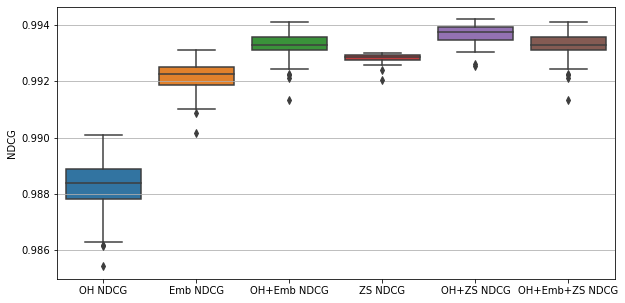

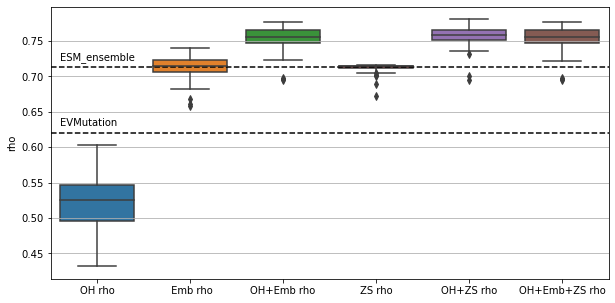

In [12]:
#increasing the NDCG increase ridge model performance
df_ndcg = pd.DataFrame(data=results_ndcg.reshape(100,6), columns= ['OH NDCG', 'Emb NDCG', 'OH+Emb NDCG', 'ZS NDCG', 'OH+ZS NDCG', 'OH+Emb+ZS NDCG'])
df_rho = pd.DataFrame(data=results_rho.reshape(100,6), columns= ['OH rho',' Emb rho', 'OH+Emb rho', 'ZS rho','OH+ZS rho', 'OH+Emb+ZS rho'])

plt.figure(figsize=(10,5))
plt.grid()
ax = sns.boxplot(data = df_ndcg)
#plt.axhline(y = ndcg(all_all_fitness, all_scores), color = 'k', linestyle = '--')
plt.ylabel('NDCG')
plt.savefig('384_96_xgb_NDCG.jpg')

plt.figure(figsize=(10,5))
plt.grid()
ax = sns.boxplot(data = df_rho)
for i in range(all_all_scores.shape[1]):
    value = spearmanr(all_all_fitness, all_all_scores[:,i])[0]
    plt.axhline(y = value, color = 'k', linestyle = '--')
    plt.text(-0.4, value+0.01, attribute_names[i])
plt.ylabel('rho')

print(np.mean(df_rho, axis =0))
#plt.savefig('384_96_xgb_rho.jpg')


In [46]:
spearmanr(all_all_fitness, all_all_scores[0])

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 36521 and the array at index 1 has size 2

In [52]:
all_all_scores[:,0].shape

(36521,)

In [7]:
ndcg(np.exp(all_fitness), all_scores)

0.9614241067207571

In [8]:
ndcg(np.exp(all_fitness), np.random.rand(len(all_scores)))
#why is this number so high for the pabp dataset?

0.9176753481501306

(array([1.4015e+04, 5.7570e+03, 8.6130e+03, 7.8280e+03, 1.2730e+03,
        1.7100e+02, 4.3000e+01, 7.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([2.3520000e-03, 2.8901680e-01, 5.7568160e-01, 8.6234640e-01,
        1.1490112e+00, 1.4356760e+00, 1.7223408e+00, 2.0090056e+00,
        2.2956704e+00, 2.5823352e+00, 2.8690000e+00]),
 <BarContainer object of 10 artists>)

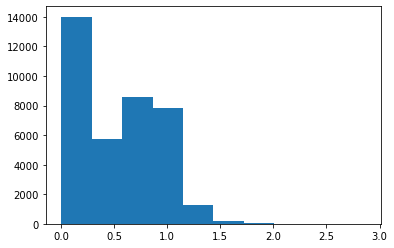

In [9]:
plt.hist(np.exp(all_fitness))

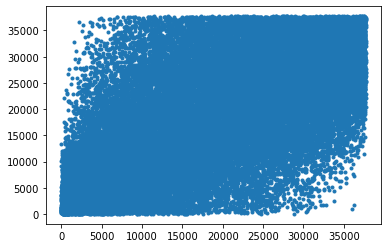

In [86]:
plt.plot(dataset.data['EVMutation'].rank(), dataset.data['log_fitness'].rank(), '.')

Text(336.9714285714286, 0.5, 'Actual fitness')

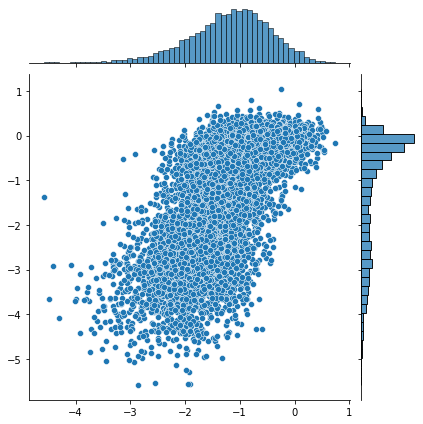

In [8]:
ax = sns.jointplot(x = y_pred_test,y = y_test)
plt.xlabel('Predicted fitness')
plt.ylabel('Actual fitness')

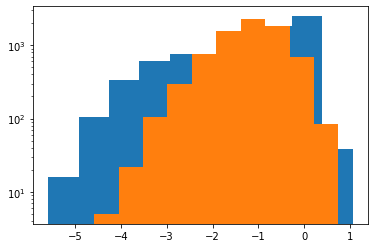

In [13]:
plt.hist(y_test)
plt.hist(y_pred_test)
plt.yscale('log')